## Chapter 11: Principles of Feature Learning

# 11.5 Ensembling methods

Intro goes here.

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
from mlrefined_libraries import basics_library 

# demos for this notebook
regress_plotter = nonlib.nonlinear_regression_demos_multiple_panels
classif_plotter = nonlib.nonlinear_classification_visualizer_multiple_panels
static_plotter = optlib.static_plotter.Visualizer()
basic_runner = nonlib.basic_runner
classif_plotter_crossval = nonlib.crossval_classification_visualizer
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 
import copy
import math

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

#### <span style="color:#a50e3e;">Example. </span>  K-folds and regression

- Use the **median** not the **mean** as your average for regression
- This is exactly what we use naturally for classification as 'winner take all'
- Also, the mean of a list of numbers is dumb.

In [18]:
# load in dataset
# csvname = datapath + 'noisy_sin_sample.csv'
# csvname = datapath + 'universal_regression_samples_0.csv'
csvname = datapath + 'nonlinear_reg_data.csv'
csvname = datapath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

In [19]:
# num_pts = 17
# r = np.random.permutation(y.size)[:num_pts]
# x_samples = x[:,r]
# y_samples = y[:,r]

Perform a k-fold split of the input data.

In [20]:
# function for splitting dataset into k folds
def split_data(y,num_folds):
    # split data into k equal (as possible) sized sets
    L = np.size(y)
    order = np.random.permutation(L)
    c = np.ones((L,1))
    L = int(np.round((1/num_folds)*L))
    for s in np.arange(0,num_folds-2):
        c[order[s*L:(s+1)*L]] = s + 2
    c[order[(num_folds-1)*L:]] = num_folds
    return c

In [21]:
num_folds = 3
c = split_data(y,num_folds)

In [41]:
# This code cell will not be shown in the HTML version of this notebook
degree = 15
train_portion = 1/float(num_folds)
runs1 = []
for j in range(1,num_folds+1):
    # initialize with input/output data
    mylib1 = nonlib.reg_lib.super_setup.Setup(x,y)

    # perform preprocessing step(s) - especially input normalization
    mylib1.preprocessing_steps(normalizer = 'none')
    
    # pluck out indices of current training / validation sets
    valid_inds = np.argwhere(c == (j))
    valid_inds = [v[0] for v in valid_inds]

    train_inds = np.argwhere(c != (j))
    train_inds = [v[0] for v in train_inds]
    
    # load this info into the model
    mylib1.train_inds = train_inds
    mylib1.valid_inds = valid_inds
    mylib1.x_train = mylib1.x[:,train_inds]
    mylib1.y_train = mylib1.y[:,train_inds]
    mylib1.x_valid = mylib1.x[:,valid_inds]
    mylib1.y_valid = mylib1.y[:,valid_inds]
    train_portion = 1/float(num_folds)
    mylib1.train_portion = train_portion
    
    # loop over models to try
    for d in range(1,degree+1):
        # choose cost
        mylib1.choose_cost(name = 'least_squares')

        # choose dimensions of fully connected multilayer perceptron layers
        mylib1.choose_features(name = 'polys',degree = d)

        # fit an optimization
        mylib1.fit(algo = 'newtons_method',max_its = 1,verbose = False)
        
    # keep only the best degree, based on lowest validation cost
    val_costs = [mylib1.valid_cost_histories[i][1] for i in range(degree)]
    min_ind = np.argmin(val_costs)
    min_val = val_costs[min_ind]
    
    mylib1.train_cost_histories = mylib1.train_cost_histories[min_ind][1]
    mylib1.valid_cost_histories = mylib1.valid_cost_histories[min_ind][1]
    mylib1.weight_histories = mylib1.weight_histories[min_ind][1]
    mylib1.choose_features(name = 'polys',degree = min_ind + 1)

    # store 
    runs1.append(copy.deepcopy(mylib1))

<IPython.core.display.Javascript object>


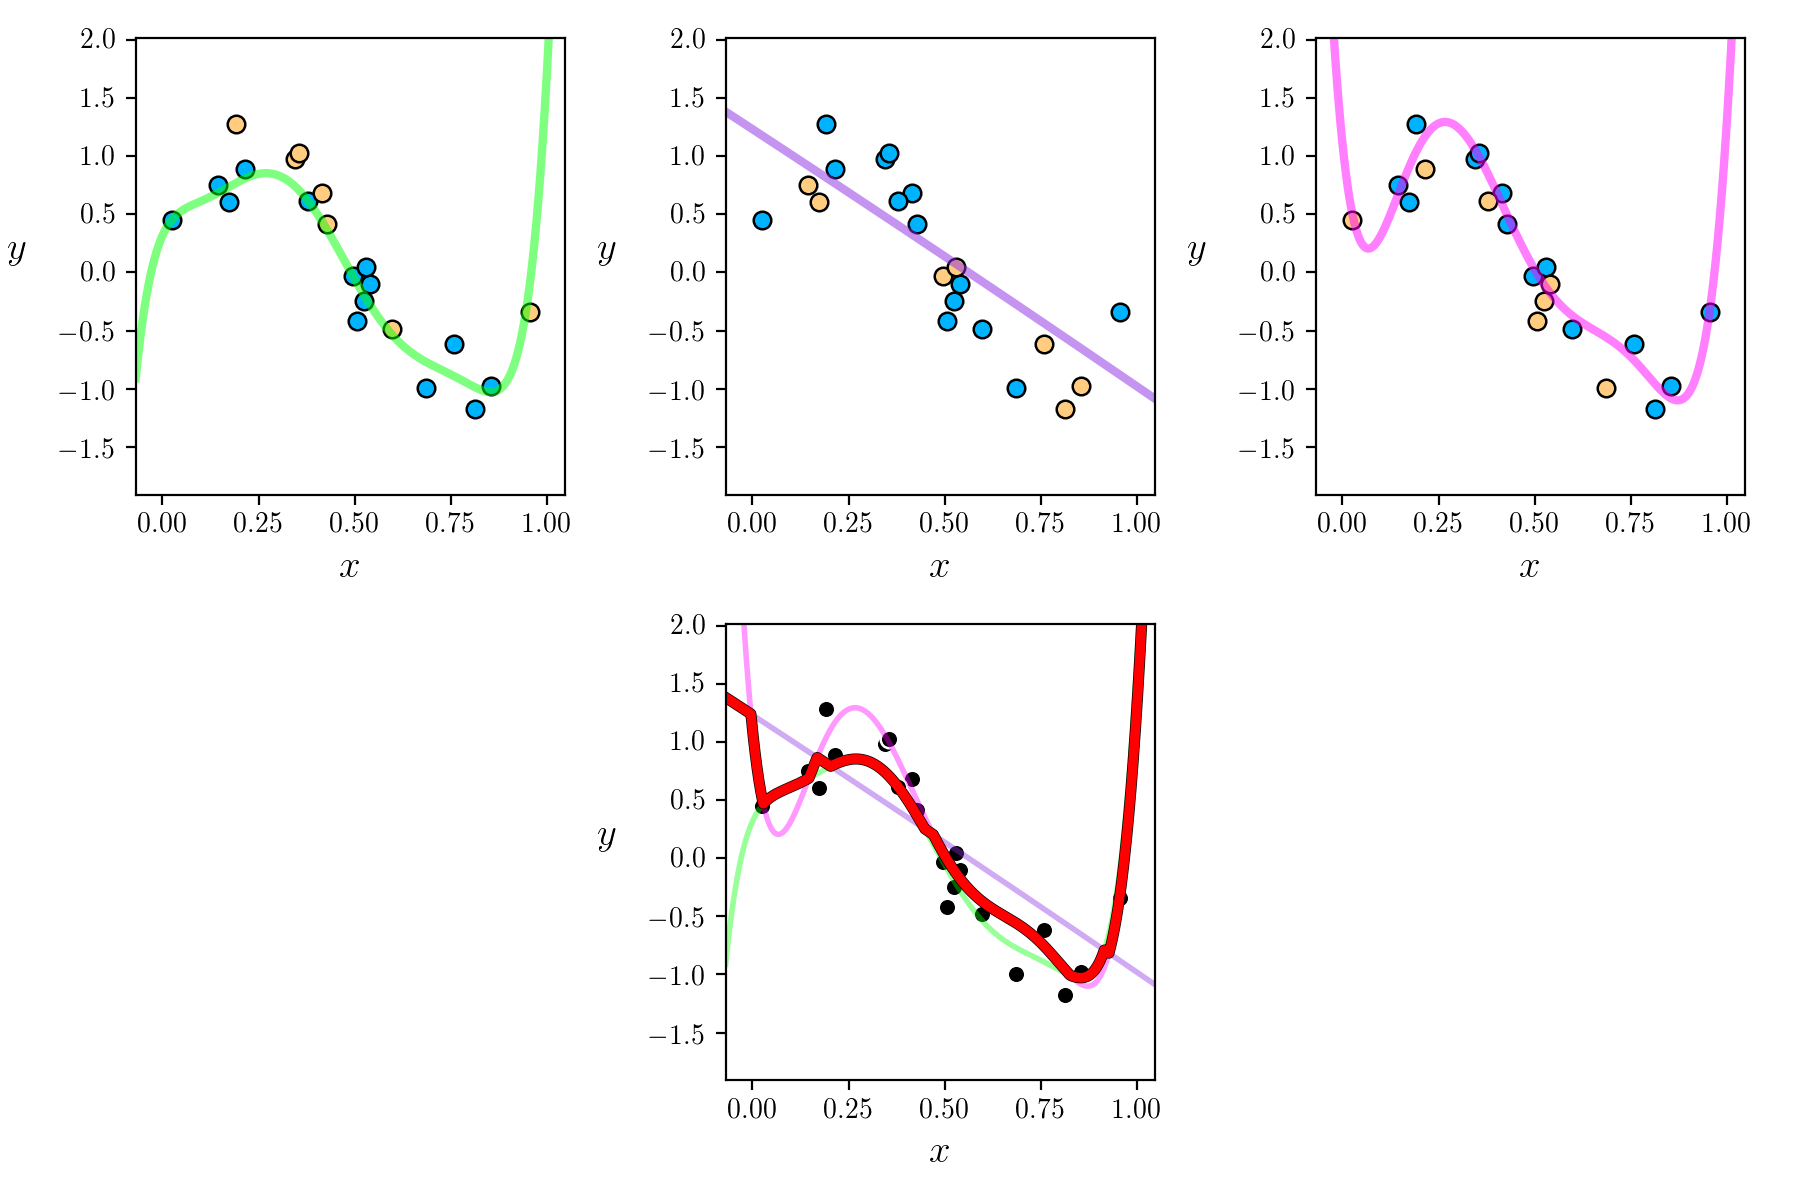

In [42]:
demo1 = nonlib.regression_bagging_visualizers.Visualizer(csvname)
demo1.show_runs(runs1)

#### <span style="color:#a50e3e;">Example. </span>  Bagging a prototuype nonlinear regression dataset

<IPython.core.display.Javascript object>


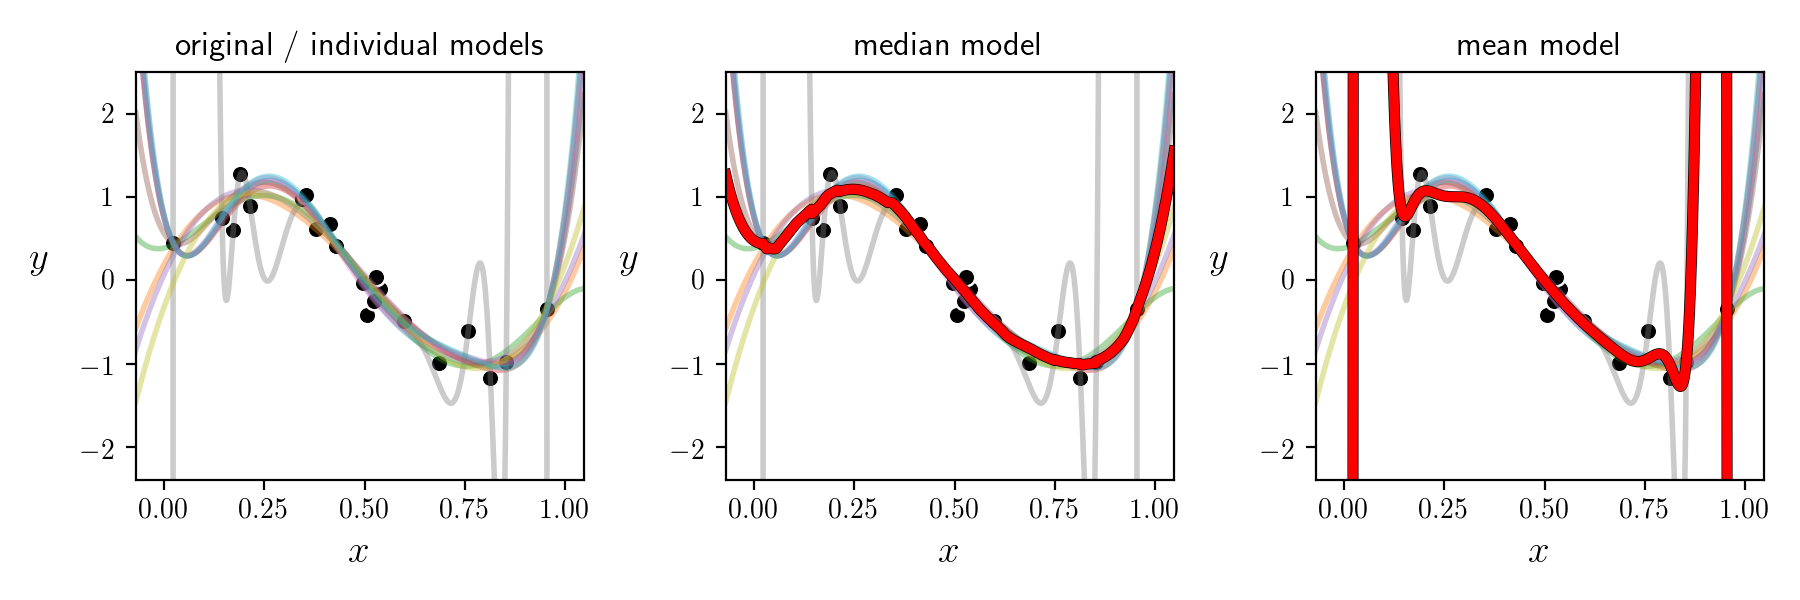

In [32]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
# csvname = datapath + 'nonlinear_reg_data.csv'
csvname = datapath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# run bagg
degree = 20
num_baggs = 10
train_portion = 0.8
runs2 = []
for j in range(num_baggs):
    # initialize with input/output data
    mylib2 = nonlib.reg_lib.super_setup.Setup(x,y)

    # perform preprocessing step(s) - especially input normalization
    mylib2.preprocessing_steps(normalizer = 'none')
    
    # pluck out indices of current training / validation sets
    mylib2.make_train_val_split(train_portion = train_portion)
    
    # loop over models to try
    for d in range(1,degree+1):
        # choose cost
        mylib2.choose_cost(name = 'least_squares')

        # choose dimensions of fully connected multilayer perceptron layers
        mylib2.choose_features(name = 'polys',degree = d)

        # fit an optimization
        mylib2.fit(algo = 'newtons_method',max_its = 1,verbose = False)
        
    # keep only the best degree, based on lowest validation cost
    val_costs = [mylib2.valid_cost_histories[i][1] for i in range(degree)]
    min_ind = np.argmin(val_costs)
    min_val = val_costs[min_ind]
    
    mylib2.train_cost_histories = mylib2.train_cost_histories[min_ind][1]
    mylib2.valid_cost_histories = mylib2.valid_cost_histories[min_ind][1]
    mylib2.weight_histories = mylib2.weight_histories[min_ind][1]
    mylib2.choose_features(name = 'polys',degree = min_ind + 1)

    # store 
    runs2.append(copy.deepcopy(mylib2))

# plot 
demo1 = nonlib.regression_bagging_visualizers.Visualizer(csvname)
demo1.show_baggs(runs2)

#### <span style="color:#a50e3e;">Example. </span> Two-class classification and K-folds

- Again, the **median model** makes sense
- This is equivalently a **mode model**

In [67]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname = datapath + '2_eggs.csv'

data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# run bagg
degree = 10

num_folds = 3
c = split_data(y,num_folds)

train_portion = 0.66
runs3 = []
for j in range(1,num_folds+1):
    # initialize with input/output data
    mylib3 = nonlib.reg_lib.super_setup.Setup(x,y)

    # perform preprocessing step(s) - especially input normalization
    mylib3.preprocessing_steps(name = 'none')
    
    # pluck out indices of current training / validation sets
    valid_inds = np.argwhere(c == (j))
    valid_inds = [v[0] for v in valid_inds]

    train_inds = np.argwhere(c != (j))
    train_inds = [v[0] for v in train_inds]
    
    # load this info into the model
    mylib3.train_inds = train_inds
    mylib3.valid_inds = valid_inds
    mylib3.x_train = mylib3.x[:,train_inds]
    mylib3.y_train = mylib3.y[:,train_inds]
    mylib3.x_valid = mylib3.x[:,valid_inds]
    mylib3.y_valid = mylib3.y[:,valid_inds]
    train_portion = 1/float(num_folds)
    mylib3.train_portion = train_portion
    
    # loop over models to try
    for d in range(1,degree+1):
        # choose cost
        mylib3.choose_cost(name = 'softmax')

        # choose dimensions of fully connected multilayer perceptron layers
        mylib3.choose_features(name = 'polys',degree = d)

        # fit an optimization
        mylib3.fit(algo = 'newtons_method',max_its = 3,verbose = False)
        
    # keep only the best degree, based on lowest validation cost
    val_costs = [mylib3.valid_count_histories[i][1] for i in range(degree)]
    max_ind = np.argmin(val_costs)
    max_val = val_costs[max_ind]
        
    mylib3.train_cost_histories = mylib3.train_cost_histories[max_ind][1]
    mylib3.valid_cost_histories = mylib3.valid_cost_histories[max_ind][1]
    mylib3.train_count_histories = mylib3.train_count_histories[max_ind][1]
    mylib3.valid_count_histories = mylib3.valid_count_histories[max_ind][1]
    mylib3.weight_histories = mylib3.weight_histories[max_ind][1]
    mylib3.choose_features(name = 'polys',degree = max_ind + 1)

    # store 
    runs3.append(copy.deepcopy(mylib3))

<IPython.core.display.Javascript object>


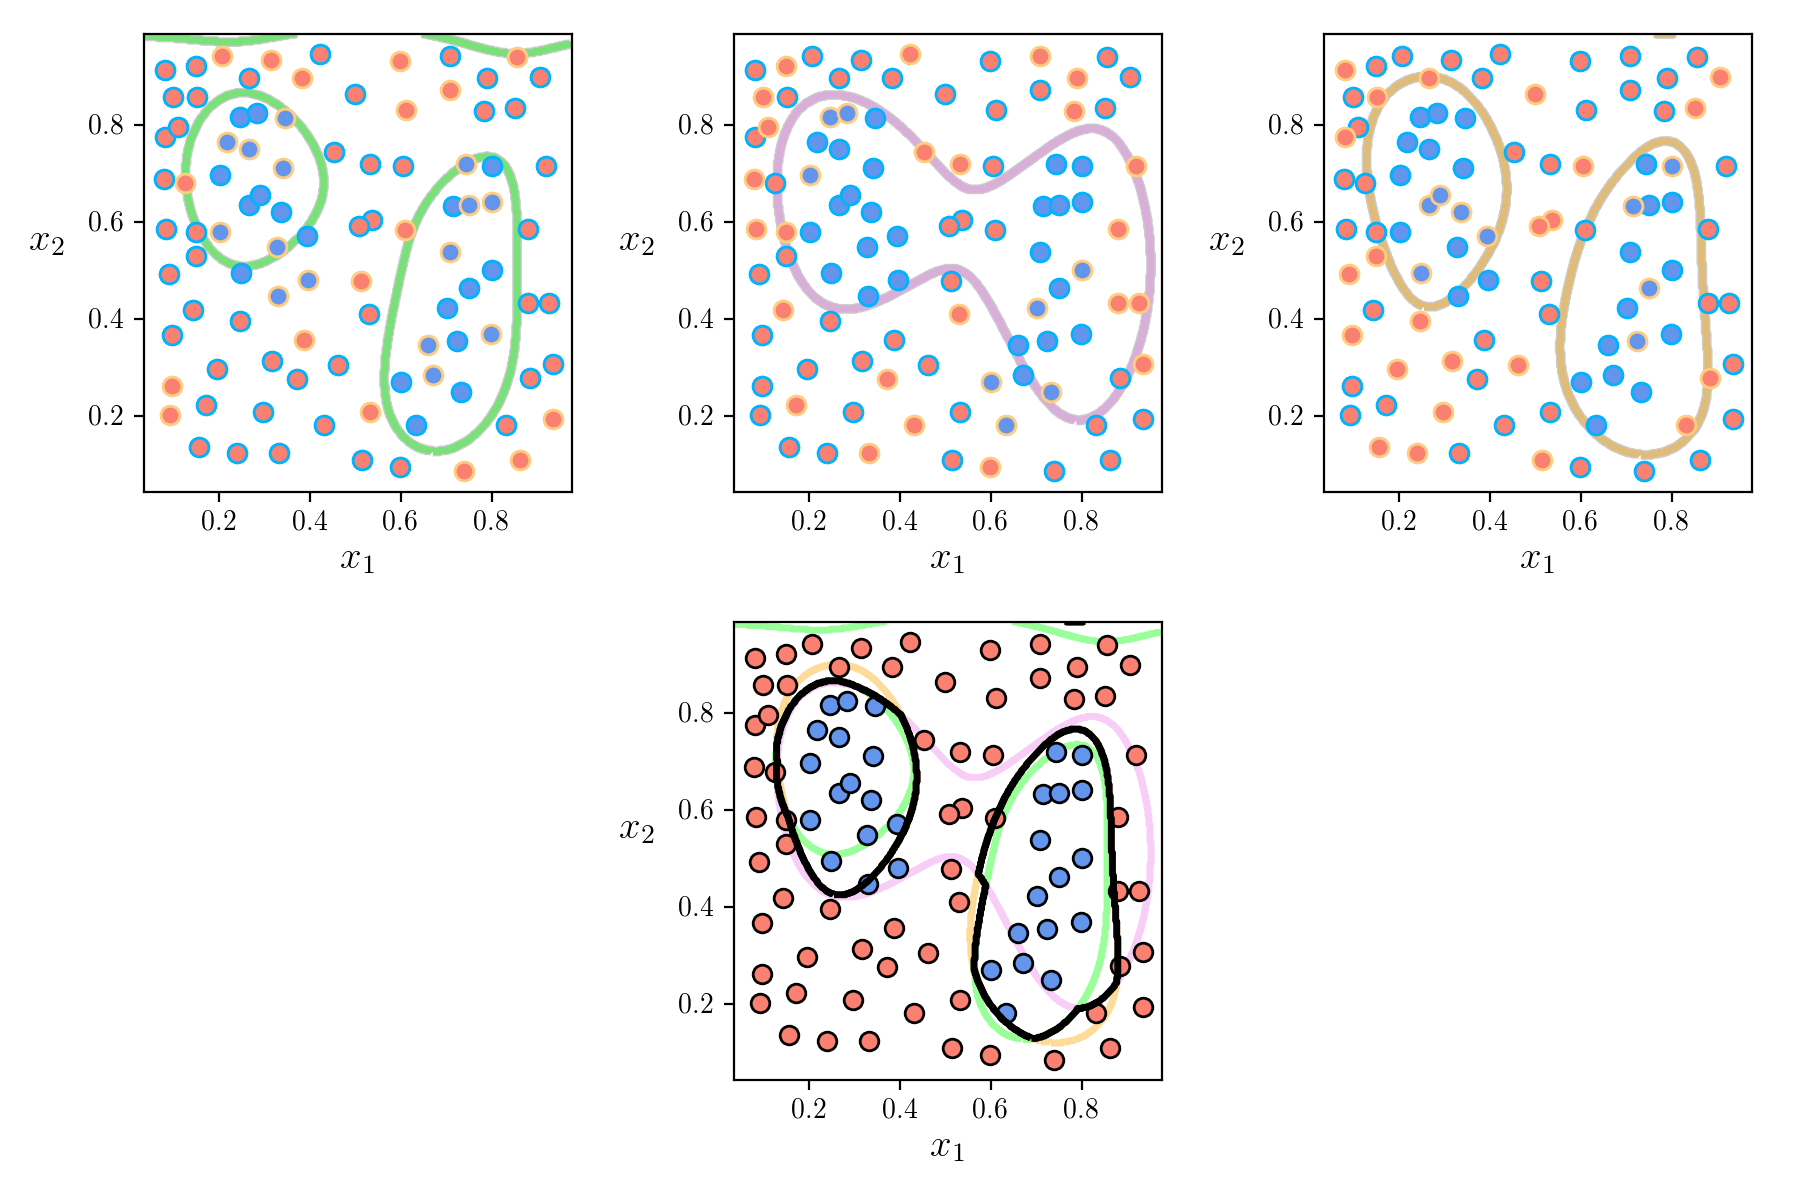

In [68]:
# plot 
demo3 = nonlib.classification_bagging_visualizers.Visualizer(csvname)
demo3.show_runs(runs3)

#### <span style="color:#a50e3e;">Example. </span> Bagging two-class classification

<IPython.core.display.Javascript object>


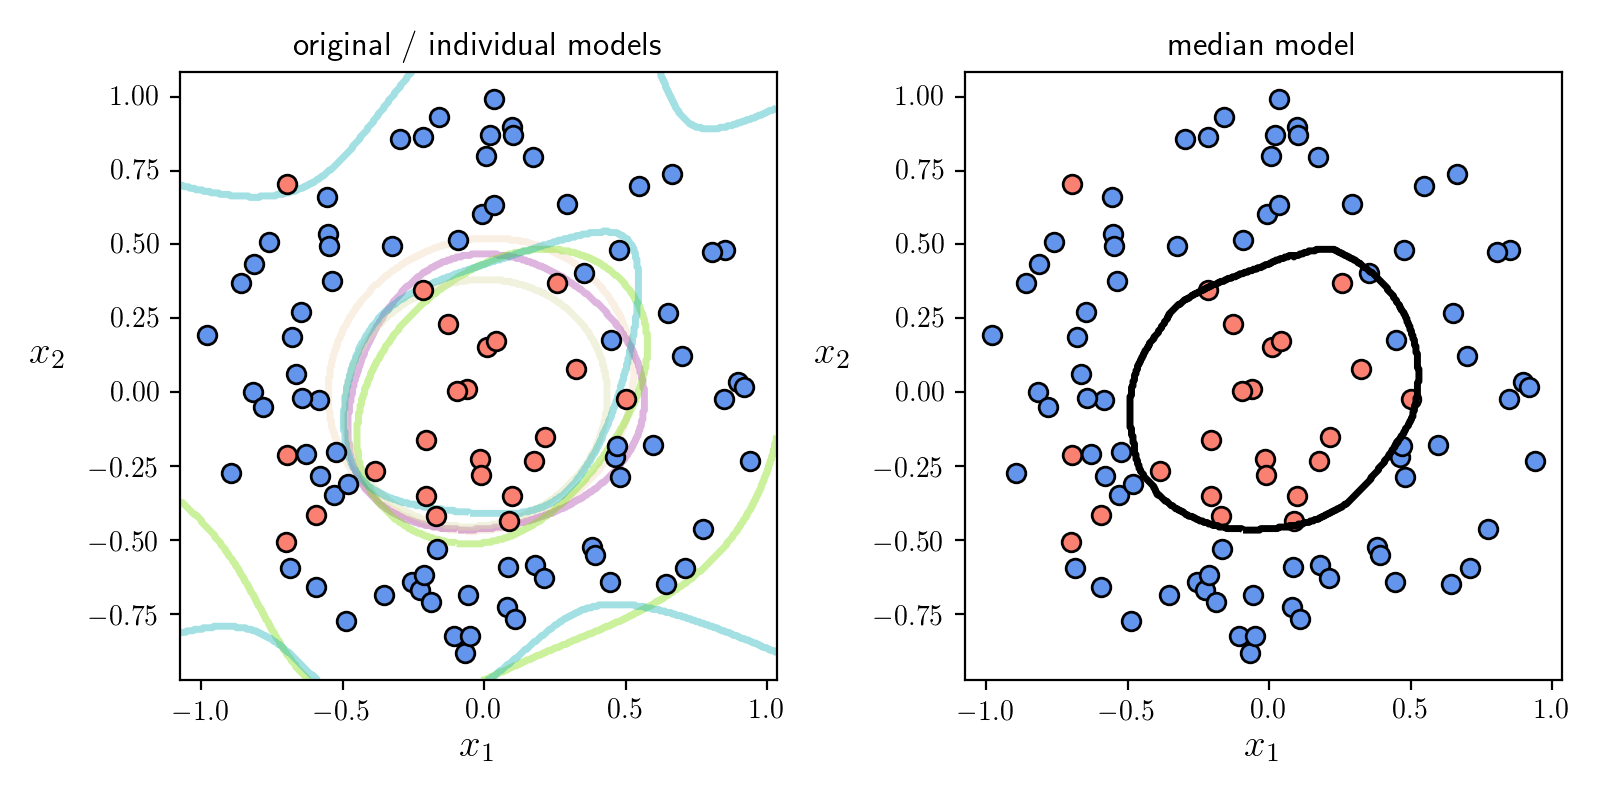

In [81]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname = datapath + 'new_circle_data.csv'

data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# run bagg
degree = 10
num_baggs = 5
train_portion = 0.66
runs4 = []
for j in range(num_baggs):
    # initialize with input/output data
    mylib4 = nonlib.reg_lib.super_setup.Setup(x,y)

    # perform preprocessing step(s) - especially input normalization
    mylib4.preprocessing_steps(normalizer = 'none')
    
    # pluck out indices of current training / validation sets
    mylib4.make_train_val_split(train_portion = train_portion)
    
    # loop over models to try
    for d in range(1,degree+1):
        # choose cost
        mylib4.choose_cost(name = 'softmax')

        # choose dimensions of fully connected multilayer perceptron layers
        mylib4.choose_features(name = 'polys',degree = d)

        # fit an optimization
        mylib4.fit(algo = 'newtons_method',max_its = 2,verbose = False,lam = 10**(-6))
        
    # keep only the best degree, based on lowest validation cost
    val_costs = [mylib4.valid_count_histories[i][1] for i in range(degree)]
    min_ind = np.argmin(val_costs)
    min_val = val_costs[min_ind]
        
    mylib4.train_cost_histories = mylib4.train_cost_histories[min_ind][1]
    mylib4.valid_cost_histories = mylib4.valid_cost_histories[min_ind][1]
    mylib4.train_count_histories = mylib4.train_count_histories[min_ind][1]
    mylib4.valid_count_histories = mylib4.valid_count_histories[min_ind][1]
    mylib4.weight_histories = mylib4.weight_histories[min_ind][1]
    mylib4.choose_features(name = 'polys',degree = min_ind + 1)

    # store 
    runs4.append(copy.deepcopy(mylib4))
    
# plot 
demo4 = nonlib.classification_bagging_visualizers.Visualizer(csvname)
demo4.show_baggs(runs4)

<IPython.core.display.Javascript object>


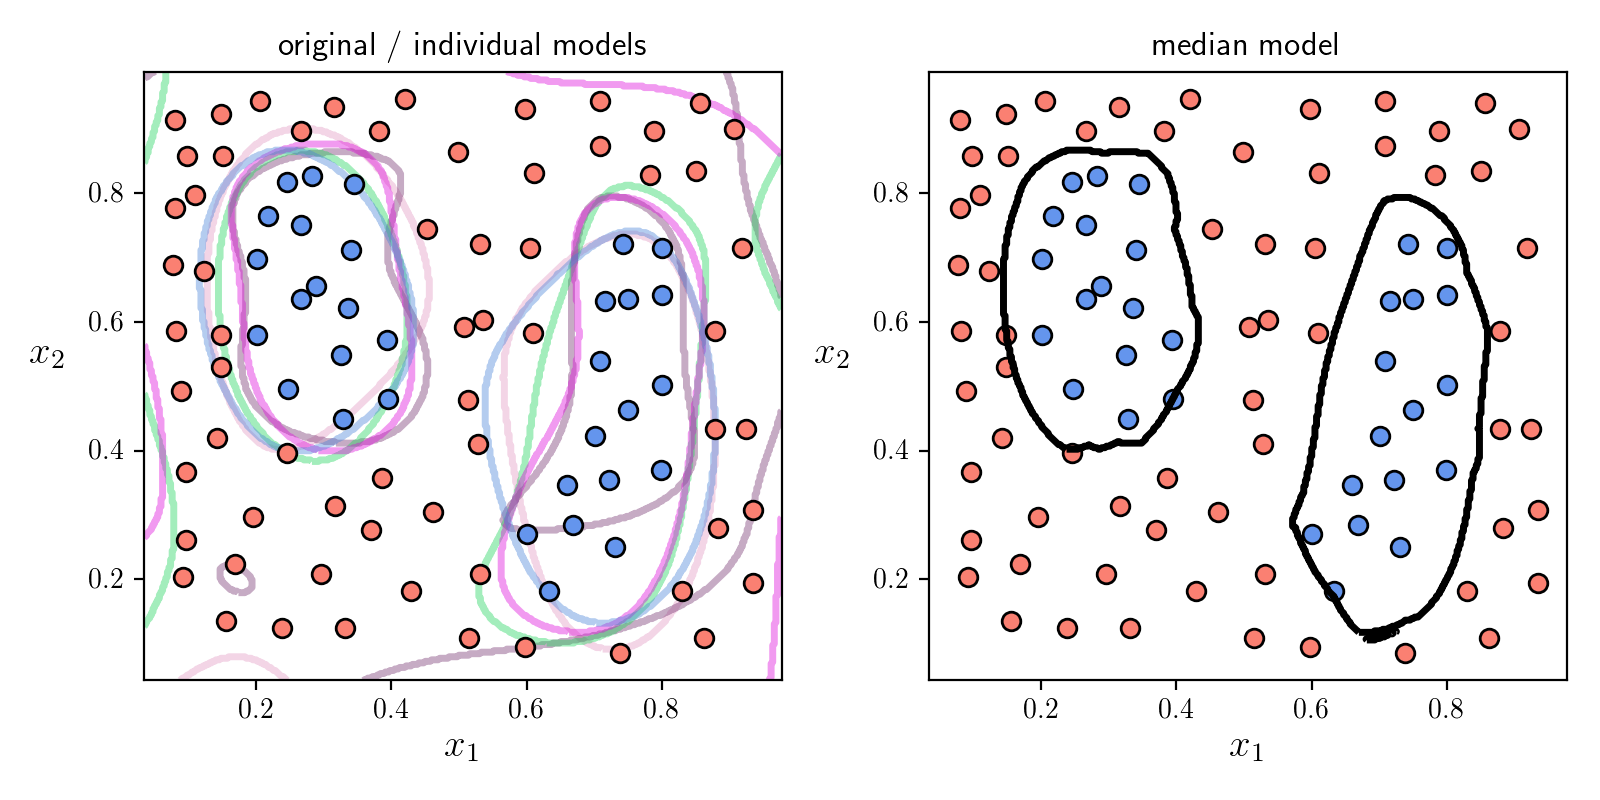

In [83]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname = datapath + '2_eggs.csv'

data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# run bagg
degree = 10
num_baggs = 5
train_portion = 0.66
runs5 = []
for j in range(num_baggs):
    # initialize with input/output data
    mylib5 = nonlib.reg_lib.super_setup.Setup(x,y)

    # perform preprocessing step(s) - especially input normalization
    mylib5.preprocessing_steps(normalizer = 'none')
    
    # pluck out indices of current training / validation sets
    mylib5.make_train_val_split(train_portion = train_portion)
    
    # loop over models to try
    for d in range(1,degree+1):
        # choose cost
        mylib5.choose_cost(name = 'softmax')

        # choose dimensions of fully connected multilayer perceptron layers
        mylib5.choose_features(name = 'polys',degree = d)

        # fit an optimization
        mylib5.fit(algo = 'newtons_method',max_its = 2,verbose = False,lam = 10**(-6))
        
    # keep only the best degree, based on lowest validation cost
    val_costs = [mylib5.valid_count_histories[i][1] for i in range(degree)]
    min_ind = np.argmin(val_costs)
    min_val = val_costs[min_ind]
        
    mylib5.train_cost_histories = mylib5.train_cost_histories[min_ind][1]
    mylib5.valid_cost_histories = mylib5.valid_cost_histories[min_ind][1]
    mylib5.train_count_histories = mylib5.train_count_histories[min_ind][1]
    mylib5.valid_count_histories = mylib5.valid_count_histories[min_ind][1]
    mylib5.weight_histories = mylib5.weight_histories[min_ind][1]
    mylib5.choose_features(name = 'polys',degree = min_ind + 1)

    # store 
    runs5.append(copy.deepcopy(mylib5))
    
# plot 
demo5 = nonlib.classification_bagging_visualizers.Visualizer(csvname)
demo5.show_baggs(runs5)

<IPython.core.display.Javascript object>


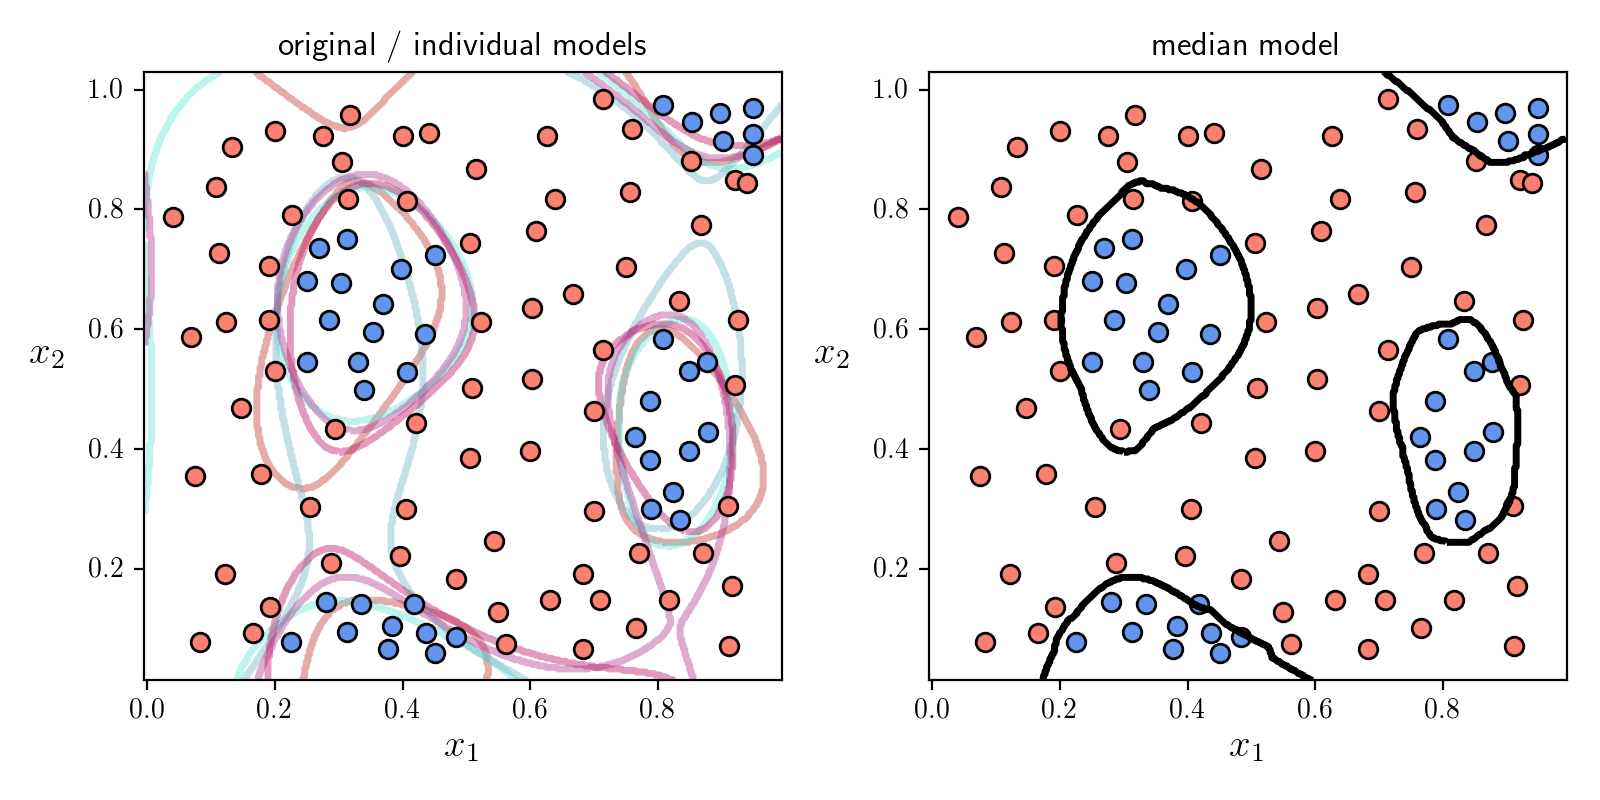

In [93]:
# This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname = datapath + '4eggs_data.csv'

data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

# run bagg
degree = 10
num_baggs = 5
train_portion = 0.66
runs6 = []
for j in range(num_baggs):
    # initialize with input/output data
    mylib6 = nonlib.reg_lib.super_setup.Setup(x,y)

    # perform preprocessing step(s) - especially input normalization
    mylib6.preprocessing_steps(name = 'standard')
    
    # pluck out indices of current training / validation sets
    mylib6.make_train_val_split(train_portion = train_portion)
    
    # loop over models to try
    for d in range(1,degree+1):
        # choose cost
        mylib6.choose_cost(name = 'softmax')

        # choose dimensions of fully connected multilayer perceptron layers
        mylib6.choose_features(name = 'polys',degree = d)

        # fit an optimization
        mylib6.fit(algo = 'newtons_method',max_its = 2,verbose = False,lam = 10**(-8))
        
    # keep only the best degree, based on lowest validation cost
    val_costs = [mylib6.valid_count_histories[i][1] for i in range(degree)]
    min_ind = np.argmin(val_costs)
    min_val = val_costs[min_ind]
        
    mylib6.train_cost_histories = mylib6.train_cost_histories[min_ind][1]
    mylib6.valid_cost_histories = mylib6.valid_cost_histories[min_ind][1]
    mylib6.train_count_histories = mylib6.train_count_histories[min_ind][1]
    mylib6.valid_count_histories = mylib6.valid_count_histories[min_ind][1]
    mylib6.weight_histories = mylib6.weight_histories[min_ind][1]
    mylib6.choose_features(name = 'polys',degree = min_ind + 1)

    # store 
    runs6.append(copy.deepcopy(mylib6))
    
# plot 
demo6 = nonlib.classification_bagging_visualizers.Visualizer(csvname)
demo6.show_baggs(runs6)